In [1]:
from scipy import stats
import numpy as np
import pandas as pd


DAYS = 30

TRIALS_MEAN = 5000
TRIALS_STD = 200**2
TRIALS_COV_FACTOR = 0.999

PRIOR_ALPHA = 20
PRIOR_BETA = TRIALS_MEAN - PRIOR_ALPHA

PROB_A_ALPHA = PRIOR_ALPHA - 1
PROB_A_BETA = TRIALS_MEAN - PROB_A_ALPHA
PROB_B_ALPHA = PRIOR_ALPHA + 1
PROB_B_BETA = TRIALS_MEAN - PROB_B_ALPHA
BETAS_COPULA_COV_FACTOR = 0.5

np.random.seed(0)


def make_data():
    def make_trials():
        """Creates strongly correlated daily number of trials"""
        mvnorm = stats.multivariate_normal(
            mean=[TRIALS_MEAN, TRIALS_MEAN],
            cov=[[TRIALS_STD, TRIALS_COV_FACTOR*TRIALS_STD],
                 [TRIALS_COV_FACTOR*TRIALS_STD, TRIALS_STD]])
        return mvnorm.rvs(DAYS).astype(int)

    def make_probs():
        """Creates correlated daily probs of success using normal copula"""

        def covariate(rv1: stats.rv_continuous, rv2: stats.rv_continuous, cov_factor: float, n: int):
            def make_copula():
                mvnorm = stats.multivariate_normal(mean=[0, 0], cov=[[1., cov_factor],
                                                                     [cov_factor, 1.]])
                # Generate random samples from multivariate normal with covariance
                x = mvnorm.rvs(n)
                return stats.norm.cdf(x=x)

            copula = make_copula()
            s1 = rv1.ppf(copula[:, 0])
            s2 = rv2.ppf(copula[:, 1])
            return np.vstack((s1, s2))

        beta_a = stats.beta(PROB_A_ALPHA, PROB_A_BETA)
        beta_b = stats.beta(PROB_B_ALPHA, PROB_B_BETA)
        return covariate(rv1=beta_a, rv2=beta_b, cov_factor=BETAS_COPULA_COV_FACTOR, n=DAYS).T

    trials = make_trials()
    probs = make_probs()
    # creates daily number of successes by sampling from binomial with corresponding number of trials
    # and prob of success

    successes = np.random.binomial(trials, probs)

    df = pd.DataFrame(
        np.hstack(
            (trials, probs, successes)
        ),
        columns=['trials_a', 'trials_b', 'prob_a', 'prob_b', 'successes_a', 'successes_b']
    )
    df['cr_a'] = df['successes_a'] / df['trials_a']
    df['cr_b'] = df['successes_b'] / df['trials_b']
    return df


df = make_data()
print(df.head())

   trials_a  trials_b    prob_a    prob_b  successes_a  successes_b      cr_a  \
0    4645.0    4649.0  0.004429  0.004510         15.0         28.0  0.003229   
1    4794.0    4814.0  0.005251  0.003992         28.0         34.0  0.005841   
2    4630.0    4622.0  0.003775  0.003821         13.0         22.0  0.002808   
3    4810.0    4809.0  0.004845  0.005806         19.0         29.0  0.003950   
4    5018.0    5022.0  0.004427  0.004914         17.0         30.0  0.003388   

       cr_b  
0  0.006023  
1  0.007063  
2  0.004760  
3  0.006030  
4  0.005974  


In [3]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model_five_params:
    alpha_3 = alpha_4 = 1
    alpha_1 = alpha_2 = PRIOR_ALPHA - alpha_3
    alpha_5 = PRIOR_BETA - alpha_3
    
    u_1 = pm.Gamma('u_1', alpha=alpha_1, beta=1)
    u_2 = pm.Gamma('u_2', alpha=alpha_2, beta=1)
    u_3 = pm.Gamma('u_3', alpha=alpha_3, beta=1)
    u_4 = pm.Gamma('u_4', alpha=alpha_4, beta=1)
    u_5 = pm.Gamma('u_5', alpha=alpha_5, beta=1)
    
    beta_a = pm.Deterministic('beta_a', (u_1+u_3)/(u_1+u_3+u_4+u_5))
    beta_b = pm.Deterministic('beta_b', (u_2+u_4)/(u_2+u_3+u_4+u_5))

    beta = tt.stack([beta_a, beta_b])
    obs = pm.Binomial(
        'obs',
        n=df[['trials_a', 'trials_b']].values,
        p=beta,
        observed=df[['successes_a', 'successes_b']].values
    )

with model_five_params:
    step = pm.Metropolis()
    trace_five_params = pm.sample(200000, tune=20000, step=step, init='advi')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [u_5]
>Metropolis: [u_4]
>Metropolis: [u_3]
>Metropolis: [u_2]
>Metropolis: [u_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 880000/880000 [04:37<00:00, 3166.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


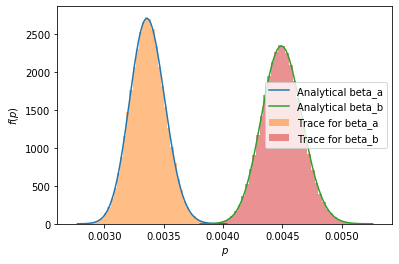

In [5]:
beta_a_exact = stats.beta(
    a=PRIOR_ALPHA + df['successes_a'].sum(),
    b=PRIOR_BETA + df['trials_a'].sum() - df['successes_a'].sum()
)
beta_b_exact = stats.beta(
    a=PRIOR_ALPHA + df['successes_b'].sum(),
    b=PRIOR_BETA + df['trials_b'].sum() - df['successes_b'].sum()
)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1)

x_0 = np.linspace(beta_a_exact.ppf(0.00001), beta_a_exact.ppf(0.99999), 1000)
ax.plot(x_0, beta_a_exact.pdf(x_0), label='Analytical beta_a')
ax.hist(trace_five_params.get_values('beta_a', burn=50000), density=True, bins=50, alpha=0.5, label='Trace for beta_a')

x_1 = np.linspace(beta_b_exact.ppf(0.00001), beta_b_exact.ppf(0.99999), 1000)
ax.plot(x_1, beta_b_exact.pdf(x_1), label='Analytical beta_b')
ax.hist(trace_five_params.get_values('beta_b', burn=50000), density=True, bins=50, alpha=0.5, label='Trace for beta_b')

ax.legend()
ax.set_xlabel('$p$')
ax.set_ylabel('$f(p)$')

plt.show()

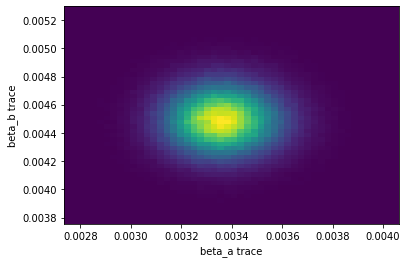

In [6]:
fig, ax = plt.subplots()
ax.hist2d(
    trace_five_params.get_values('beta_a', burn=50000),
    trace_five_params.get_values('beta_b', burn=50000),
    bins=50
)
ax.set_xlabel('beta_a trace')
ax.set_ylabel('beta_b trace')
plt.show()